### **IMPORTATION DES BIBLIOTHÈQUES**

In [1]:
# gestion des données
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# Machine Learning et Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Rescaling, Normalization, CenterCrop, RandomFlip
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# l'évaluation des performances
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ajout du chemin pour accéder aux fichiers locaux
sys.path.append('/kaggle/input/fire-data')

### **PRÉ-TRAITEMENT DES DONNÉES**

In [2]:
def process_dataset(dataset_path):
    image_dir = Path(dataset_path)
    filepaths = list(image_dir.glob('**/*.JPG')) + list(image_dir.glob('**/*.jpg')) + list(image_dir.glob('**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)

    return dataset_df

def walk_through_dir(dataset_paths):
    all_datasets = pd.DataFrame(columns=['Filepath', 'Label'])

    for dataset_path in dataset_paths:
        print("-" * 90)
        print(f"Processing directory: {dataset_path}")
        dataset_df = process_dataset(dataset_path)
        all_datasets = pd.concat([all_datasets, dataset_df], ignore_index=True)

    return all_datasets

In [3]:
dataset_paths = [
    "/kaggle/input/fire-data/Data/D1",
    "/kaggle/input/fire-data/Data/D2",
    "/kaggle/input/fire-data/Data/D3",
    "/kaggle/input/fire-data/Data/D4",
    "/kaggle/input/fire-data/Data/D5",
    "/kaggle/input/fire-data/Data/D6",
    "/kaggle/input/fire-data/Data/D7",
    "/kaggle/input/fire-data/Data/D8",
    "/kaggle/input/fire-data/Data/D9",
    "/kaggle/input/fire-data/Data/D10",
    "/kaggle/input/fire-data/Data/D11",
    "/kaggle/input/fire-data/Data/D12",
    "/kaggle/input/fire-data/Data/D13",
    "/kaggle/input/fire-data/Data/D14",
    "/kaggle/input/fire-data/Data/D15",
    "/kaggle/input/fire-data/Data/D16" 
]

final_dataset = walk_through_dir(dataset_paths)

print(final_dataset.info())

------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D1
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D2
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D3
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D4
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D5
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fire-data/Data/D6
------------------------------------------------------------------------------------------
Processing directory: /kaggle/input/fir

In [4]:
unique_labels = final_dataset["Label"].unique()
print(unique_labels)

['nonfire4' 'nonfire2' 'nonfire5' 'nonfire3' 'fire' 'nonfire1' 'nonfire'
 'smoke' 'nofire' 'nighttime' 'house' 'street' 'ntime' 'mtime' 'red'
 'test' 'green' 'D16']


In [5]:
label_mapping = {
    'nonfire': 0,
    'nonfire1': 0,
    'nonfire2': 0,
    'nonfire3': 0,
    'nonfire4': 0,
    'nonfire5': 0,
    'nofire': 0,
    'house': 0,
    'street': 0,
    'nighttime': 0,
    'ntime': 0,
    'mtime': 0,
    'red': 0,
    'green': 0,
    'test': 0,
    'D16': 0,    # couleurs
    'fire': 1
}

final_dataset["Label"] = final_dataset["Label"].replace(label_mapping)

final_dataset

,Filepath,Label
0,/kaggle/input/fire-data/Data/D1/nonfire4/nonfi...,0
1,/kaggle/input/fire-data/Data/D1/nonfire4/nonfi...,0
2,/kaggle/input/fire-data/Data/D1/nonfire4/nonfi...,0
3,/kaggle/input/fire-data/Data/D1/nonfire2/nonfi...,0
4,/kaggle/input/fire-data/Data/D1/nonfire2/nonfi...,0
...,...,...
61236,/kaggle/input/fire-data/Data/D16/nonfire80.png,0
61237,/kaggle/input/fire-data/Data/D16/nonfire121.png,0
61238,/kaggle/input/fire-data/Data/D16/nonfire115.png,0
61239,/kaggle/input/fire-data/Data/D16/nonfire164.png,0


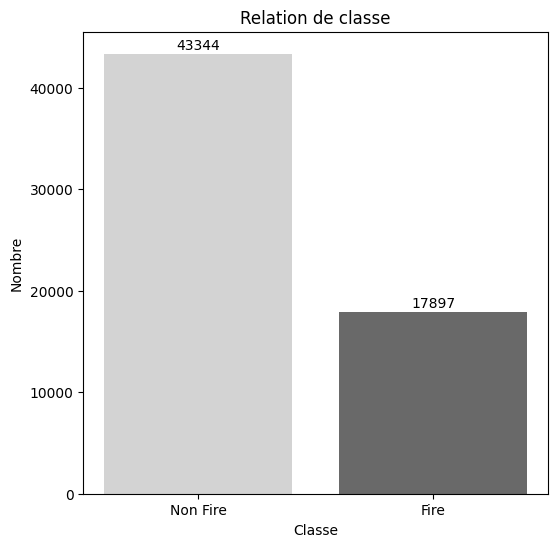

In [6]:
class_counts = final_dataset['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(class_counts.index, class_counts.values, color=['#d3d3d3', '#696969'])
plt.xlabel('Classe')
plt.ylabel('Nombre')
plt.title('Relation de classe')
plt.xticks(class_counts.index, ['Non Fire', 'Fire'])


for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.01 * max(class_counts.values), str(value), ha='center')

plt.show()

In [7]:
unique_labels_new = final_dataset["Label"].unique()

# 0 ---> Non fire | 1 ----> Fire
print(unique_labels_new)

[0 1]


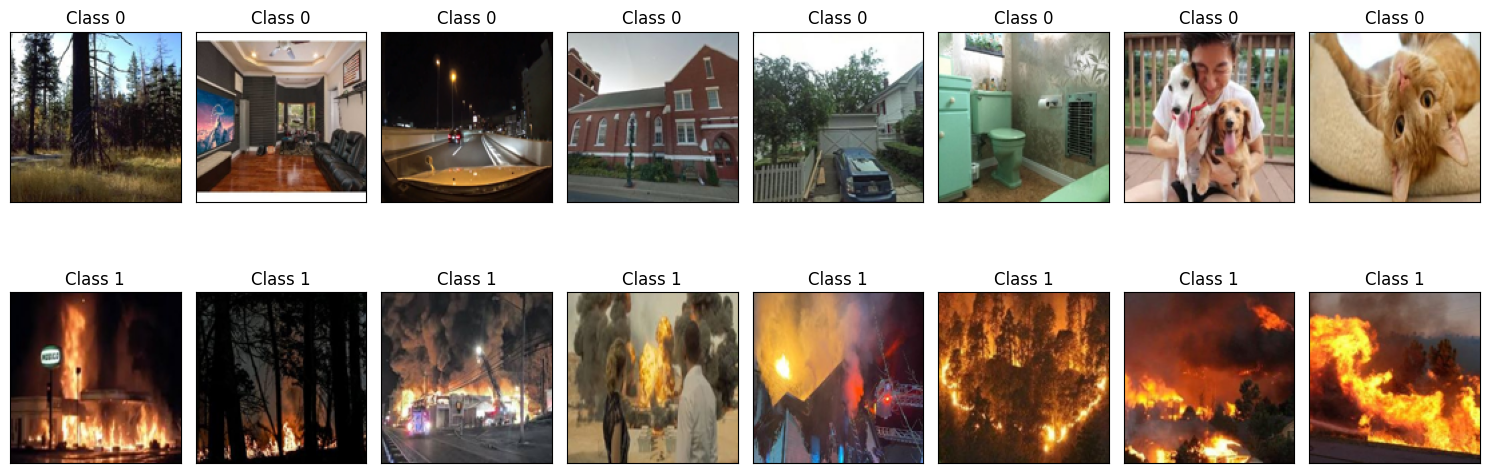

In [8]:
n_images_per_class = 8

image_size = (128, 128)

fig, axes = plt.subplots(nrows=2, ncols=n_images_per_class, figsize=(15, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

classes = [0, 1]  # 0 = Non fire, 1 = Fire

for row, class_label in enumerate(classes):
    class_images = final_dataset[final_dataset.Label == class_label]
    
    random_index = np.random.choice(class_images.index, n_images_per_class, replace=False)
    
    for col, idx in enumerate(random_index):
        image = Image.open(final_dataset.Filepath[idx]).resize(image_size)
        ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(f"Class {class_label}")

plt.tight_layout()
plt.show()

### **GÉNÉRATEURS IMAGES**

In [9]:
train_df, test_df = train_test_split(final_dataset, test_size=0.15, shuffle=True, random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 41644 validated image filenames.
Found 10410 validated image filenames.
Found 9187 validated image filenames.


In [12]:
images, labels = train_images[0]
print("Shape des images :", images.shape)
print("Shape des labels :", labels.shape)


Shape des images : (32, 224, 224, 3)
Shape des labels : (32,)


In [13]:
''' 
Affiche la répartition des classes dans un générateur d'images avec un graphique à barres.
'''
def visualize_class_distribution(generator, title):

    if hasattr(generator, 'labels'): 
        labels = generator.labels
    else:
        labels = []
        for i in range(len(generator)):
            _, batch_labels = generator[i]
            labels.extend(batch_labels)
    
    class_counts = Counter(labels)
    class_names = ['Non-Fire', 'Fire'] 
    counts = [class_counts.get(0, 0), class_counts.get(1, 0)] 
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    colors = ['#d3d3d3', '#696969']
    ax = sns.barplot(x=class_names, y=counts, palette=colors)
    
    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


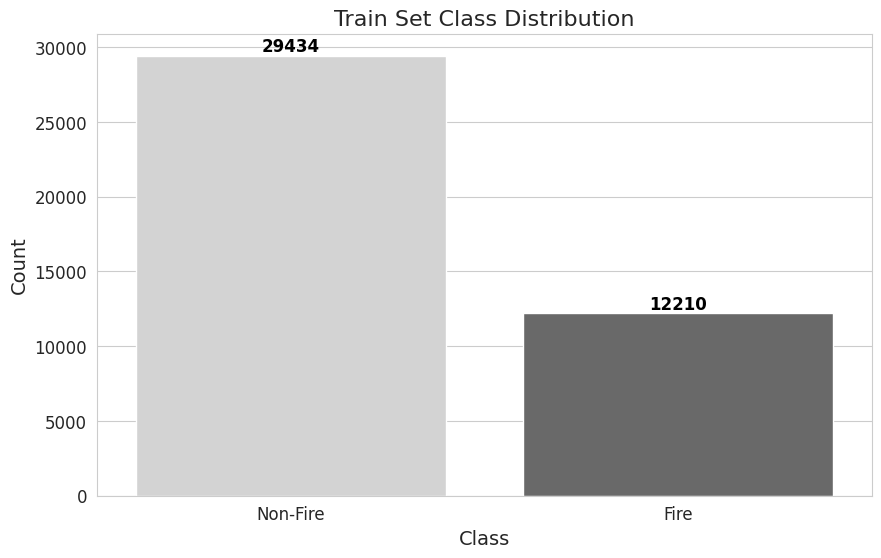

In [14]:
visualize_class_distribution(train_images, 'Train Set Class Distribution')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


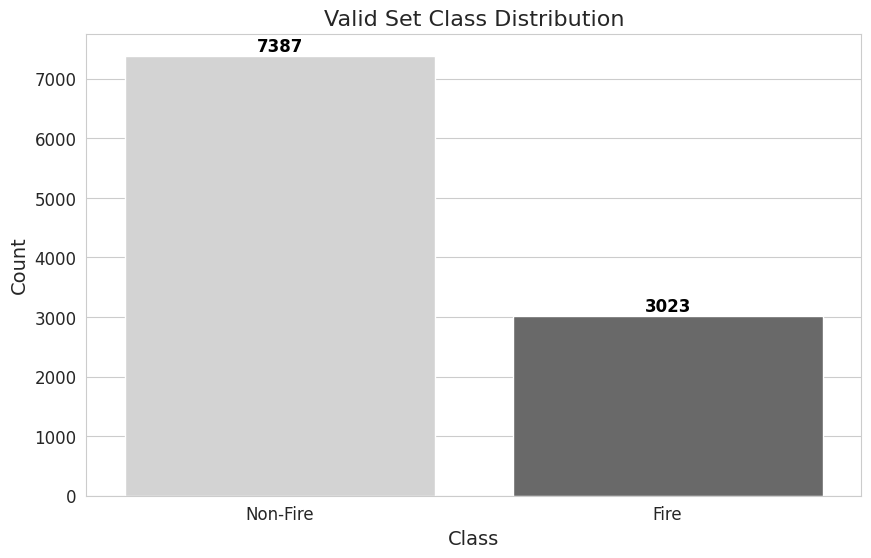

In [15]:
visualize_class_distribution(val_images, 'Valid Set Class Distribution')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


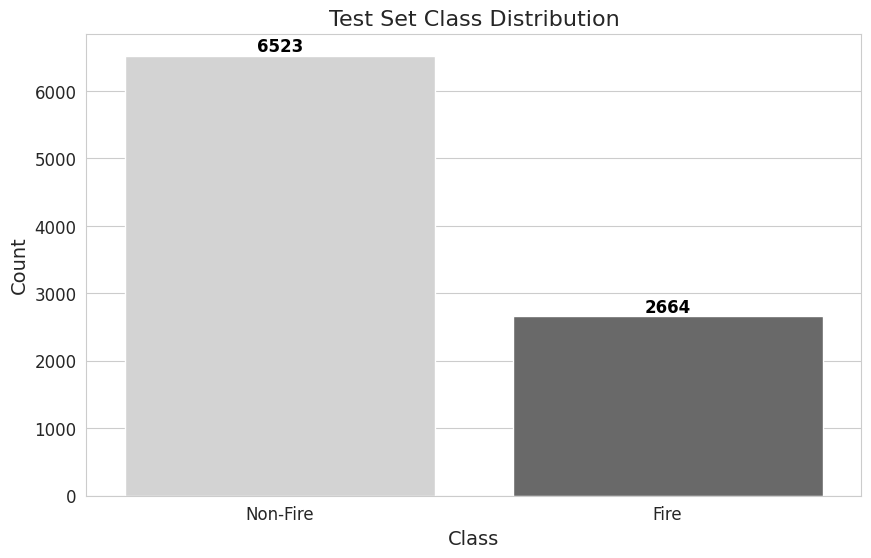

In [16]:
visualize_class_distribution(test_images, 'Test Set Class Distribution')

### **CONCEPTION DES MODÈLES**

In [17]:
def accuracy(y_true, y_pred):
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))
    total_samples = tf.cast(tf.size(y_true), tf.float32)
    accuracy_value = correct_predictions / total_samples * 100
    return accuracy_value

def precision(y_true, y_pred, positive_class=1):
    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    predicted_positive = np.sum(np.array(y_pred) == positive_class)
    precision_value = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision_value

def recall(y_true, y_pred, positive_class=1):
    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    actual_positive = np.sum(np.array(y_true) == positive_class)
    recall_value = true_positive / actual_positive if actual_positive != 0 else 0
    return recall_value

def f1_score(y_true, y_pred, positive_class=1):
    precision_value = precision(y_true, y_pred, positive_class)
    recall_value = recall(y_true, y_pred, positive_class)
    f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0
    return f1_score_value

In [18]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal")
])

In [19]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1, 
    restore_best_weights=True
)

In [20]:
checkpoint_path_Cnn = '/kaggle/working/Cnn.keras'
checkpoint_path_CnnP = '/kaggle/working/CnnParallel.keras'

In [21]:
def train_model(model, train_images, val_images, epochs=20):
    all_training_loss = []
    all_val_loss = []
    all_training_acc = []
    all_val_acc = []
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        try:
            # Entraînement pour une époque
            history = model.fit(
                train_images,
                steps_per_epoch=len(train_images),
                validation_data=val_images,
                validation_steps=len(val_images),
                epochs=1,
                callbacks=[
                    early_stopping,
                    checkpoint_callback
                ]
            )
            
            all_training_loss.append(history.history['loss'][0])
            all_val_loss.append(history.history['val_loss'][0])
            all_training_acc.append(history.history['accuracy'][0])
            all_val_acc.append(history.history['val_accuracy'][0])

        except StopIteration:
            continue

        except Exception as e:
            print(f"Une erreur s'est produite pendant l'époque {epoch}: {e}")
            break

        # Vérifier si l'arrêt précoce a été déclenché
        if early_stopping.stopped_epoch > 0:
            print("L'entraînement a été interrompu en raison de l'arrêt précoce.")
            break

    print("L'entraînement s'est terminé.")
    
    return {
        "training_loss": all_training_loss,
        "val_loss": all_val_loss,
        "training_accuracy": all_training_acc,
        "val_accuracy": all_val_acc
    }

### **1- CNN**

In [22]:
def cnn():
    inp = layers.Input((224, 224, 3))
    
    # 1ere convolution
    x = Conv2D(32, (3, 3), activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # 2eme convolution
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # 3eme convolution
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # 4eme convolution
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Aplatissement des sorties des couches de convolution
    x = Flatten()(x)

    # Couches Dense et Dropout pour la classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(1, activation='sigmoid')(x)

    model_cnn = models.Model(inputs=inp, outputs=x)

    return model_cnn

model_cnn = cnn()
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 9,893,825 (37.74 MB)

 Trainable params: 9,892,865 (37.74 MB)

 Non-trainable params: 960 (3.75 KB)

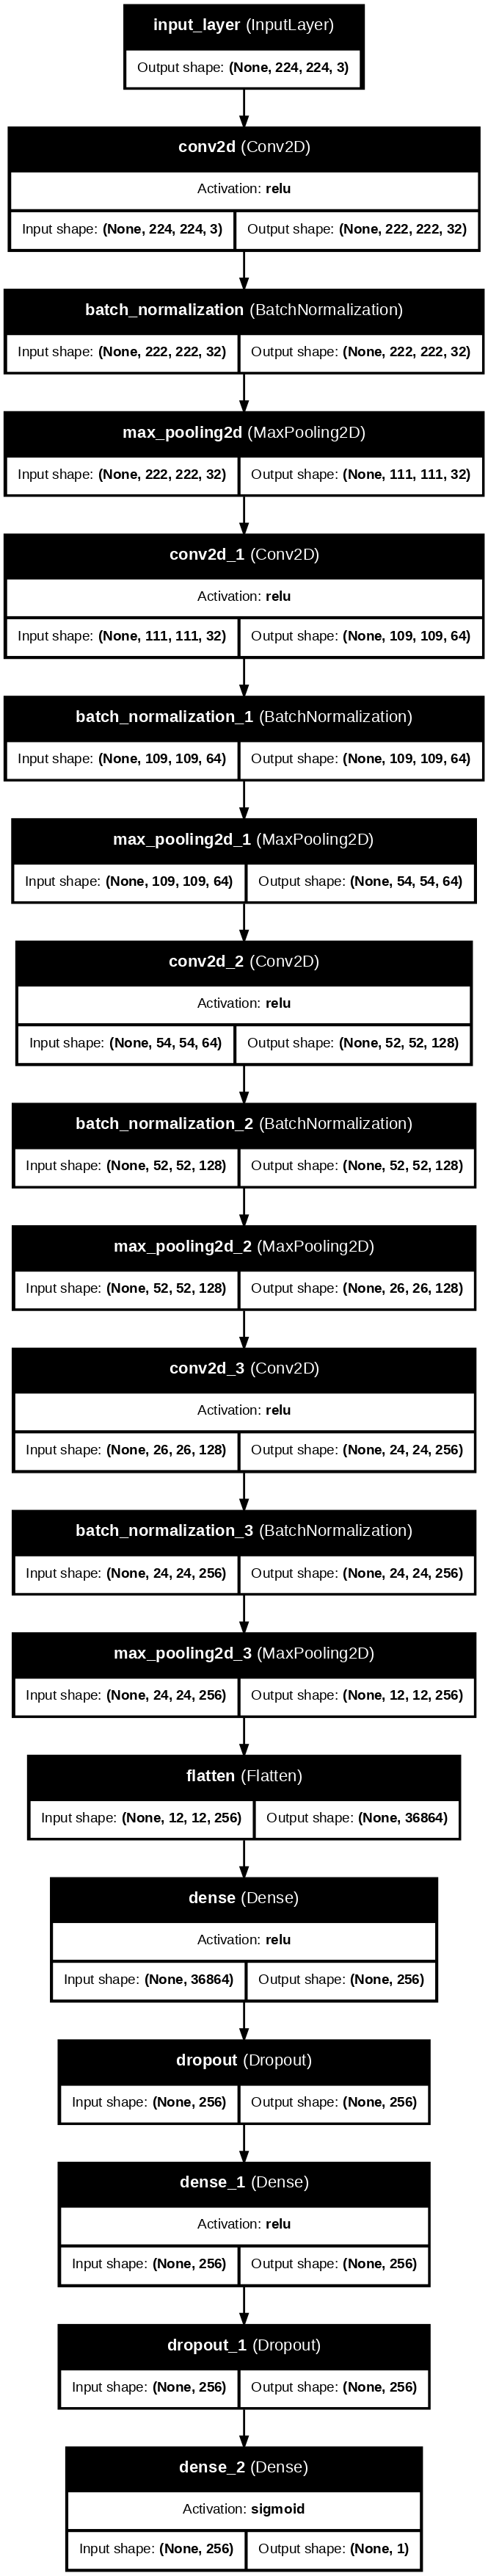

In [23]:
tf.keras.utils.plot_model(
    model_cnn,
    to_file='cnn_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [24]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Cnn,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [25]:
if __name__ == "__main__":


    model_cnn.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner le modèle
    history_data = train_model(model_cnn, train_images, val_images, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1302/1302 ━━━━━━━━━━━━━━━━━━━━ 952s 720ms/step - accuracy: 0.8651 - loss: 0.3610 - val_accuracy: 0.9189 - val_loss: 0.2158
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 769s 588ms/step - accuracy: 0.9144 - loss: 0.2327 - val_accuracy: 0.9353 - val_loss: 0.1706
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 752s 576ms/step - accuracy: 0.9308 - loss: 0.1958 - val_accuracy: 0.9463 - val_loss: 0.1525
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 752s 575ms/step - accuracy: 0.9400 - loss: 0.1731 - val_accuracy: 0.9484 - val_loss: 0.1401
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 749s 573ms/step - accuracy: 0.9465 - loss: 0.1566 - val_accuracy: 0.9505 - val_loss: 0.1334
Restoring model weights from the end of the best epoch: 1.
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 742s

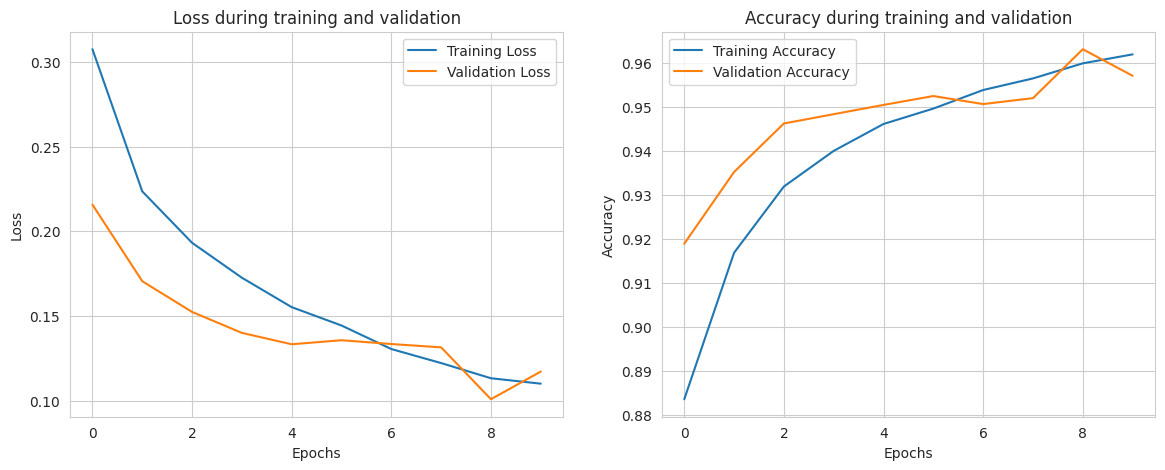

In [26]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
test_predictions = model_cnn.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 120s 414ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6523
           1       0.98      0.89      0.93      2664

    accuracy                           0.96      9187
   macro avg       0.97      0.94      0.95      9187
weighted avg       0.96      0.96      0.96      9187


Confusion Matrix:
[[6480   43]
 [ 304 2360]]

Metrics:
Accuracy: 96.22%
Precision: 0.98
Recall: 0.89
F1-Score: 0.93


### **2- CNN PARALLEL**

In [51]:
# Activer la gestion dynamique de la mémoire GPU pour éviter l'erreur OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [52]:
def cnn_parallel(img_width=224, img_height=224):
    inp = layers.Input(shape=(img_width, img_height, 3))
    
    # Branche 1 : CNN avec filtres 3x3
    cnn1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    cnn1 = layers.MaxPooling2D((2, 2))(cnn1)
    cnn1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn1)
    cnn1 = layers.MaxPooling2D((2, 2))(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    
    # Branche 2 : CNN avec filtres 5x5
    cnn2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inp)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn2)
    cnn2 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(cnn2)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn2)
    cnn2 = layers.Flatten()(cnn2)
    
    # Fusion des branches
    combined = layers.concatenate([cnn1, cnn2])
    
    # Fully connected layers
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output_layer = layers.Dense(1, activation='sigmoid')(combined)
    
    
    model = models.Model(inputs=inp, outputs=output_layer)
    return model

model_cnn_parallel = cnn_parallel(img_width=224, img_height=224)
model_cnn_parallel.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 224, 224, 32)   │          2,432 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_46          │ (None, 112, 112, 32)   │              0 │ conv2d_46[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_48          │ (None, 112, 112, 32)   │              0 │ conv2d_48[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_46[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 112, 112, 64)   │         51,264 │ max_pooling2d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 56, 56, 64)     │              0 │ conv2d_47[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_49          │ (None, 56, 56, 64)     │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 200704)         │              0 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_18 (Flatten)      │ (None, 200704)         │              0 │ max_pooling2d_49[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 401408)         │              0 │ flatten_17[0][0],      │
│ (Concatenate)             │                        │                │ flatten_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │     51,380,352 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │            129 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,453,569 (196.28 MB)

 Trainable params: 51,453,569 (196.28 MB)

 Non-trainable params: 0 (0.00 B)

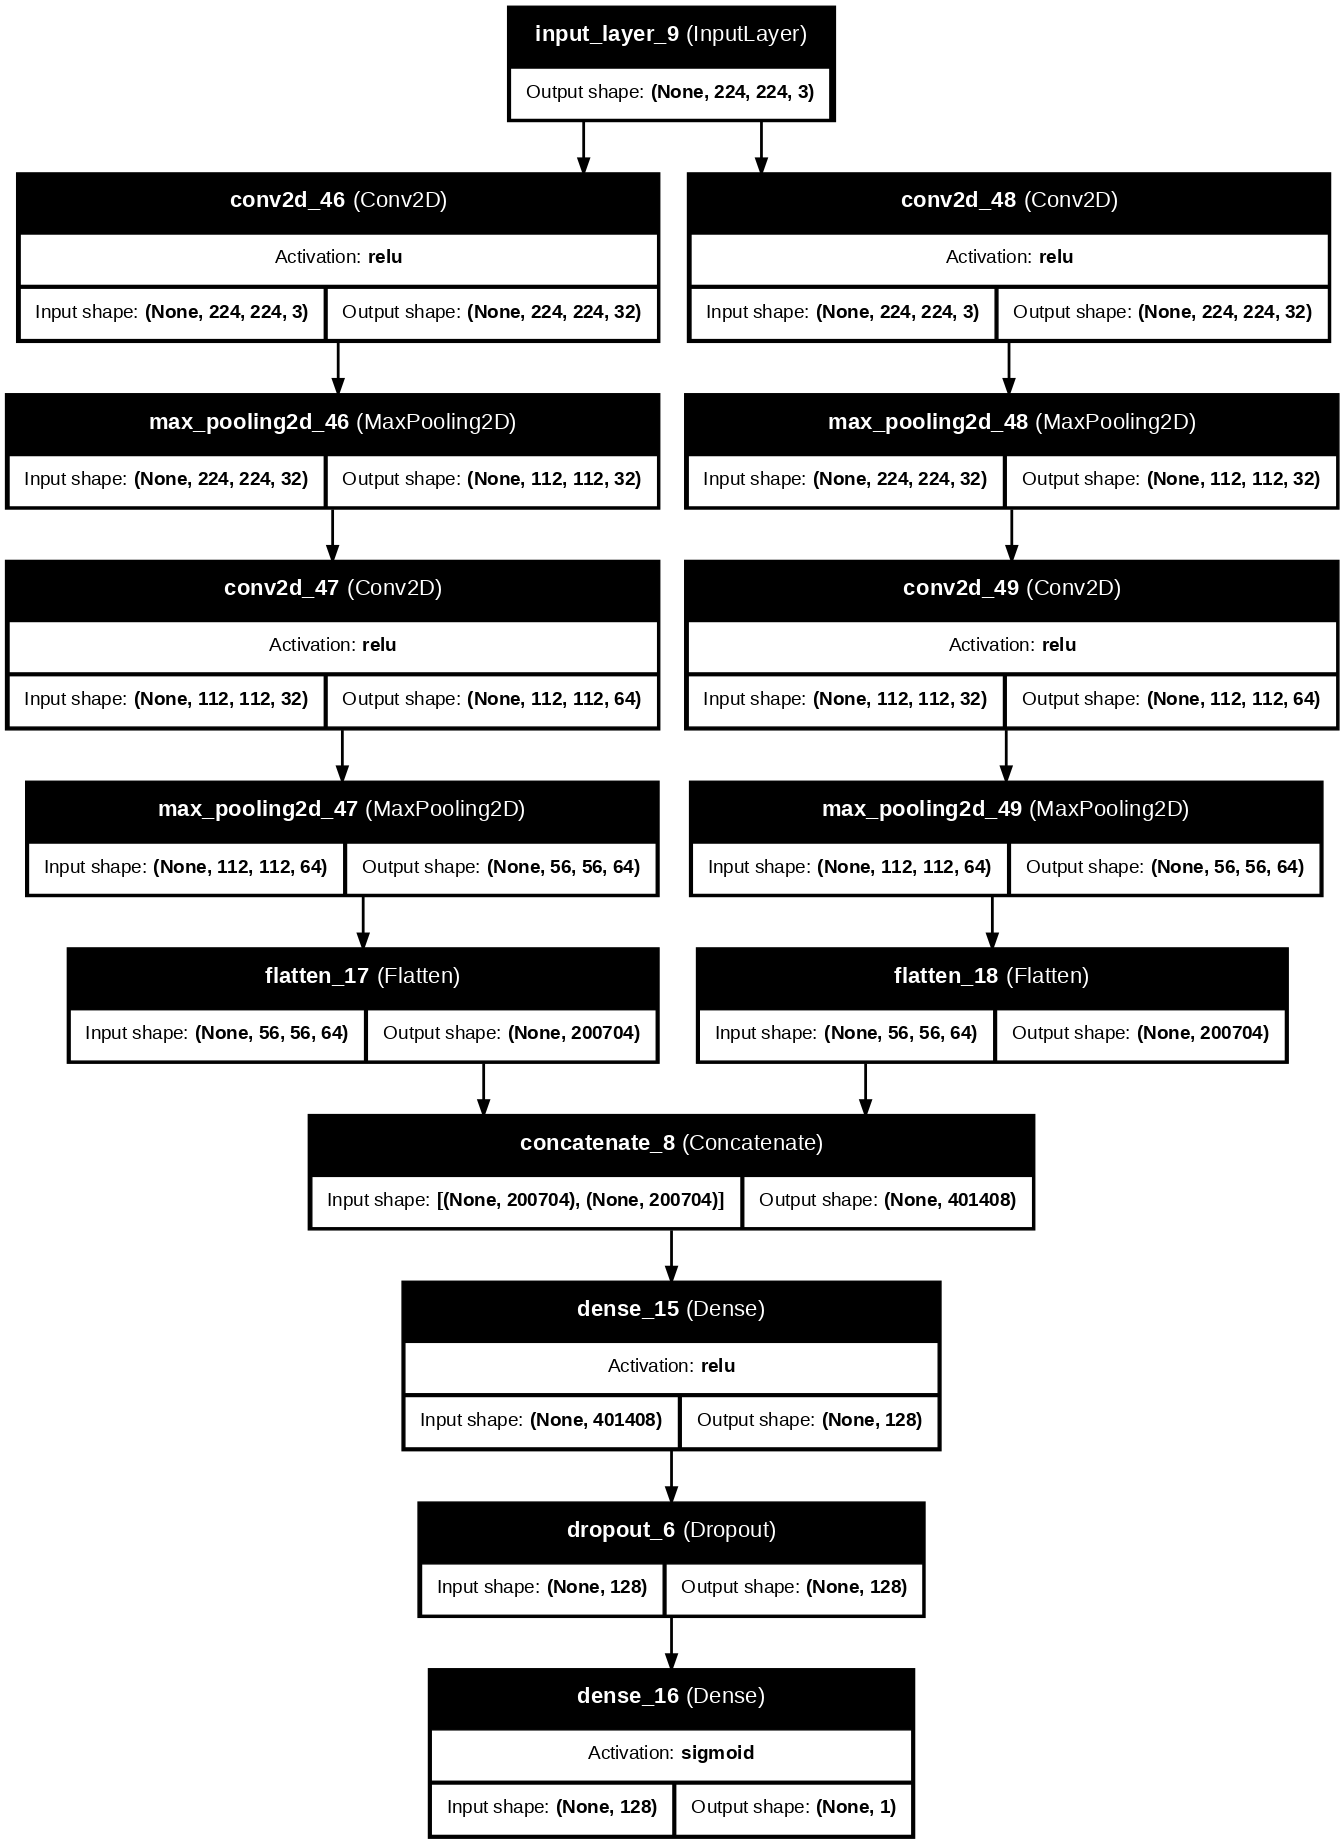

In [53]:
tf.keras.utils.plot_model(
    model_cnn_parallel,
    to_file='cnn_prallel_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [54]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_CnnP,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [55]:
if __name__ == "__main__":


    model_cnn_parallel.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner le modèle
    history_data = train_model(model_cnn_parallel, train_images, val_images, epochs=10)

Epoch 1/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 797s 607ms/step - accuracy: 0.8579 - loss: 0.3665 - val_accuracy: 0.9007 - val_loss: 0.2586
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 751s 575ms/step - accuracy: 0.9040 - loss: 0.2568 - val_accuracy: 0.9183 - val_loss: 0.2177
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 747s 571ms/step - accuracy: 0.9173 - loss: 0.2261 - val_accuracy: 0.9268 - val_loss: 0.1986
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 743s 569ms/step - accuracy: 0.9251 - loss: 0.2048 - val_accuracy: 0.9301 - val_loss: 0.1831
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 750s 573ms/step - accuracy: 0.9306 - loss: 0.1919 - val_accuracy: 0.9363 - val_loss: 0.1734
Restoring model weights from the end of the best epoch: 1.
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━

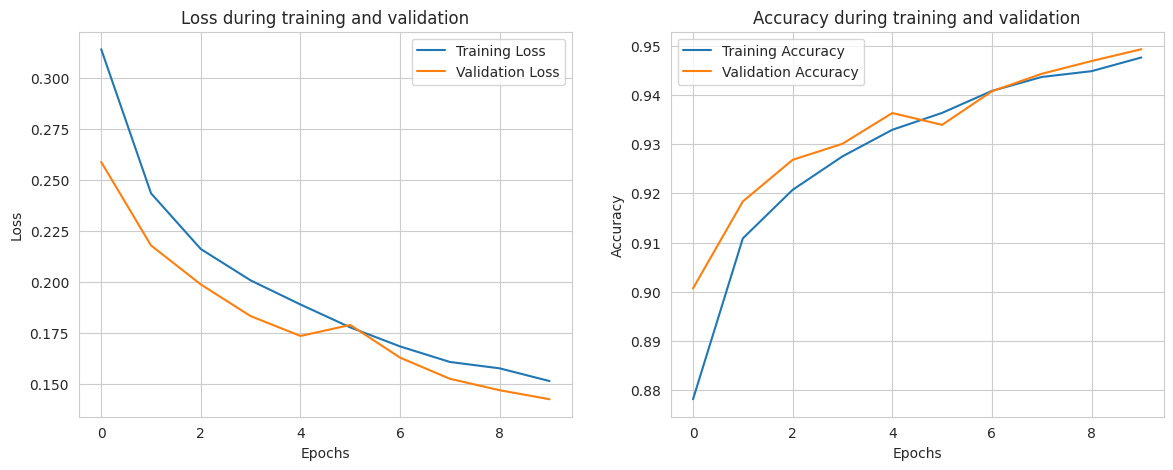

In [56]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
test_predictions = model_cnn_parallel.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 96s 333ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6523
           1       0.92      0.92      0.92      2664

    accuracy                           0.95      9187
   macro avg       0.95      0.94      0.94      9187
weighted avg       0.95      0.95      0.95      9187


Confusion Matrix:
[[6321  202]
 [ 216 2448]]

Metrics:
Accuracy: 95.45%
Precision: 0.92
Recall: 0.92
F1-Score: 0.92
